In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd

### Location problem

We want to find the smallest circle such that $n$ points are all contained in it.


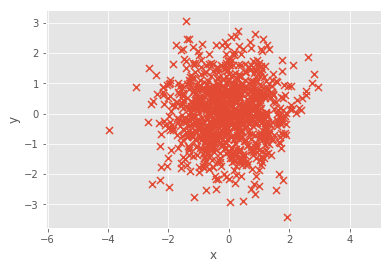

In [3]:
# pick a bunch of random points
pos = np.random.randn(1000,2)

import matplotlib.pyplot as plt
plt.scatter(pos[:,0], pos[:,1],s=50,marker=u'x')
plt.xlabel('x'), plt.ylabel('y')
plt.axis('equal')
plt.show()

In [4]:
# solution with cvxpy
from cvx.util import cvx, minimize, cvx2np

def location(pos):
    R,x = cvx.Variable(1), cvx.Variable(2)
    minimize(objective=R, constraints = [cvx.norm(row-x,2) <= R for row in pos])
    return R.value, cvx2np(x)

print(location(pos))

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

ImportError: numpy.core.multiarray failed to import

In [ ]:
# pick a bunch of random points
pos = np.random.randn(1000,2)

plt.scatter(pos[:,0], pos[:,1],s=50,marker=u'x')
plt.xlabel('x'), plt.ylabel('y')
plt.axis('equal')

radius, midpoint = location(pos)

import math
c=np.array([[radius*np.cos(a)+midpoint[0], radius*np.sin(a)+midpoint[1]] for a in np.linspace(0,2*math.pi,1000)])
plt.plot(c[:,0],c[:,1],'r')
plt.show()

# Summary

- Each constraint $\rVert{\mathbf{x}-\mathbf{c}}\lVert_2 < R$ represents a cone. Feasible domain is the intersection of all cones. 

- It is trivial to generalize (but not to plot) for points in higher dimensional spaces.

- However, all of this fails once we can construct multiple circles.